---
Import libraries:

In [1]:
## Import and install libraries:

!python --version
!pip install scikit-posthocs

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from tabulate import tabulate

from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman

Python 3.10.12


In [2]:
## Import train and test datasets (~ 80:20 split of entries).
# Also sets headers from first row of dataframe.
# Make sure the database can be read before executing.

df_train = pd.read_csv("/content/sign_mnist_train.csv", header=[0])
df_test = pd.read_csv("/content/sign_mnist_test.csv", header=[0])

# ---
# Concatenating (without duplicates) and resplit datasets due to fear of overfitting
#https://www.kaggle.com/datasets/datamunge/sign-language-mnist/discussion/379925

df_all = pd.concat([df_train, df_test], ignore_index=True).drop_duplicates()

# Determine X_train, y_train, X_test, and y_test
# Use all columns except for the first one as X (only use the pixel values)
df_X = df_all.iloc[:,1:]

# Use only the first column as y (label, ie. sign language letter
# represented as a number (0-25, 9 and 25 is skipped).
df_y = df_all.iloc[:,0]

# ---
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42, stratify=df_y)

# ---
# Reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [3]:
## Public variables
CR_LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
              'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

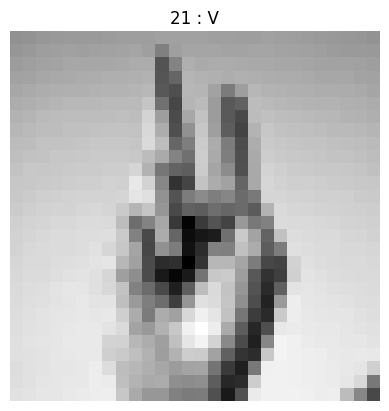

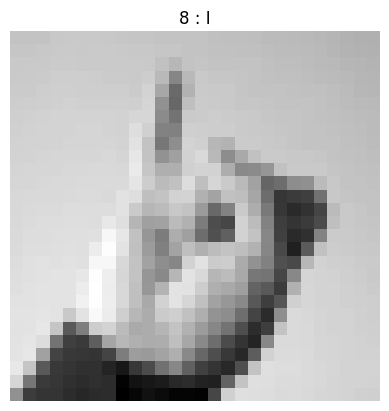

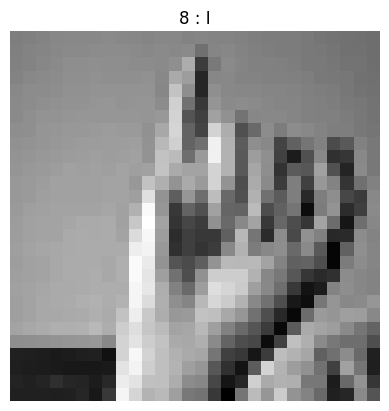

In [4]:
## Visualize some of the entries
number_of_entries_show = 3
for i in range(0, number_of_entries_show):
  img = X_train.iloc[i].to_numpy()
  img = img.reshape((28,28))
  plt.imshow(img, cmap='gray')
  plt.title(f"{y_train[i]} : {chr(ord('@') + y_train[i] + 1)}")
  plt.axis("off")
  plt.show()

In [5]:
def render_confusion_matrix(y_true, y_pred):
  # Compute the confusion matrix
  confusion_mtx = confusion_matrix(y_true, y_pred)

  # ---
  # Plot the confusion matrix
  f, ax = plt.subplots(figsize=(16, 16))

  sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens",
              linecolor="gray", fmt= '.1f', ax=ax)

  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

  # ---
  # Set ticks on axis to letters instead of numbers
  for axis in [ax.xaxis, ax.yaxis]:
      axis.set(ticks=np.arange(0.5, len(CR_LETTERS)), ticklabels=CR_LETTERS)

  plt.title("Confusion Matrix for predicting the test dataset")
  plt.show()

---
Convolutional Neural Network (CNN) (Deep Learning)

In [6]:
def CNN_algorithm(X_train, X_test, y_train, y_test):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import classification_report, precision_recall_fscore_support
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
    import numpy as np
    import time

    # Normalize the data (Preprocessing)
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    # Reshape the input data for CNN [samples, height, width, channels]
    X_train = X_train.values.reshape(-1, 28, 28, 1)
    X_test = X_test.values.reshape(-1, 28, 28, 1)

    # Hyperparameters
    IMAGE_SIZE = (28, 28, 1)
    OUTPUT_CLASSES = 26  # 26 classes (letters A-Z excluding J and Z)
    KERNEL = (3, 3)
    POOL_SIZE = (2, 2)
    MAX_NEURONS = 120
    MAX_FILTERS = 64
    LOSS_FUNCTION = 'sparse_categorical_crossentropy'
    OPTIMIZER = 'adam'
    EPOCHS = 10
    BATCH_SIZE = 256

    # Lists to store performance metrics
    list_cv_train_time = []
    list_cv_accuracy = []
    list_cv_precision = []
    list_cv_recall = []
    list_cv_f1_score = []

    # Stratified K-fold cross validation on the training set
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    fold = 1
    for train_idx, val_idx in skf.split(X_train, y_train):
        print(f"Fold #{fold}")
        X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
        X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

        # Define the CNN model
        model = Sequential([
            Conv2D(filters=int(MAX_FILTERS / 2), kernel_size=KERNEL, activation='relu', input_shape=IMAGE_SIZE),
            MaxPooling2D(pool_size=POOL_SIZE),
            Conv2D(filters=MAX_FILTERS, kernel_size=KERNEL, activation='relu'),
            MaxPooling2D(pool_size=POOL_SIZE),
            Flatten(),
            Dense(units=MAX_NEURONS, activation='relu'),
            Dense(units=int(MAX_NEURONS / 2), activation='relu'),  # Explicitly convert to int
            Dense(units=OUTPUT_CLASSES, activation='softmax')
        ])
        model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=['accuracy'])

        # Train the model
        start_time = time.time()
        model.fit(X_train_fold, y_train_fold, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
        end_time = time.time()
        train_time = end_time - start_time

        # Evaluate on validation set
        y_pred = np.argmax(model.predict(X_val_fold), axis=-1)
        accuracy = np.mean(y_val_fold == y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_val_fold, y_pred, average='weighted')

        # Store metrics
        list_cv_train_time.append(train_time)
        list_cv_accuracy.append(accuracy)
        list_cv_precision.append(precision)
        list_cv_recall.append(recall)
        list_cv_f1_score.append(f1)

        print(f"Training time: {train_time}")
        print(f"Validation accuracy: {accuracy}")
        print(f"Validation precision: {precision}")
        print(f"Validation recall: {recall}")
        print(f"Validation F1-score: {f1}")
        fold += 1

    cv_eval_metrics = [list_cv_train_time, list_cv_accuracy, list_cv_precision, list_cv_recall, list_cv_f1_score]

    # Train the final model on the entire training set
    model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

    # Evaluate on test set
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print("\nResults for predicting the test dataset:")
    print("=====================================================")
    print(classification_report(y_test, y_pred, digits=6))
    print("=====================================================")

    render_confusion_matrix(y_test, y_pred)
    return cv_eval_metrics


Fold #1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.1484 - loss: 2.9302
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6834 - loss: 1.0438
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8311 - loss: 0.5315
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9100 - loss: 0.3024
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9536 - loss: 0.1771
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9726 - loss: 0.1135
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9923 - loss: 0.0567
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9956 - loss: 0.0385
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9990 - loss: 0.0244
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9996 - loss: 0.0151
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training time: 30.649903059005737
Validation accuracy: 1.0
Validation precision: 1.0
Validation recall: 1.0
Validation

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.1481 - loss: 2.9310
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6784 - loss: 1.0613
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8275 - loss: 0.5508
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9124 - loss: 0.3048
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9616 - loss: 0.1689
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9842 - loss: 0.0908
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9947 - loss: 0.0498
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9983 - loss: 0.0290
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9995 - loss: 0.0173
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9998 - loss: 0.0119
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training time: 12.471307039260864
Validation accuracy: 1.0
Validation precision: 1.0
Validation recall: 1.0
Validation 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.1328 - loss: 2.9568
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6261 - loss: 1.2334
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8149 - loss: 0.6164
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8914 - loss: 0.3593
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9534 - loss: 0.1855
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9813 - loss: 0.0962
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9930 - loss: 0.0519
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9982 - loss: 0.0320
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9984 - loss: 0.0197
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0145
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Training time: 9.328006744384766
Validation accuracy: 0.9992779783393502
Validation precision: 0.999284229726292
Valida

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1405 - loss: 2.9651
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6610 - loss: 1.1208
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8050 - loss: 0.6241
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9003 - loss: 0.3462
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9503 - loss: 0.1967
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9802 - loss: 0.1059
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9936 - loss: 0.0551
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9965 - loss: 0.0363
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9987 - loss: 0.0211
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9994 - loss: 0.0154
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training time: 8.850760221481323
Validation accuracy: 0.9974729241877256
Validation precision: 0.9975129080239972
Valid

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.1501 - loss: 2.9477
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6555 - loss: 1.1284
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8273 - loss: 0.5659
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9073 - loss: 0.3290
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9492 - loss: 0.1965
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9789 - loss: 0.1073
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9918 - loss: 0.0589
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9970 - loss: 0.0375
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9993 - loss: 0.0211
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9997 - loss: 0.0140
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training time: 9.978255033493042
Validation accuracy: 0.9992779783393502
Validation precision: 0.999284202664011
Valida

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1322 - loss: 2.9798
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6496 - loss: 1.1649
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8248 - loss: 0.5606
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9140 - loss: 0.3018
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9520 - loss: 0.1794
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9814 - loss: 0.0930
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9932 - loss: 0.0537
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9967 - loss: 0.0340
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9995 - loss: 0.0188
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9993 - loss: 0.0146
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training time: 11.510912656784058
Validation accuracy: 0.9992779783393502
Validation precision: 0.999284202664011
Valid

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.1609 - loss: 2.8821
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6587 - loss: 1.0931
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8530 - loss: 0.4904
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9247 - loss: 0.2627
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9732 - loss: 0.1289
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9899 - loss: 0.0678
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9986 - loss: 0.0311
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9996 - loss: 0.0174
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0109
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0072
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training time: 11.531458139419556
Validation accuracy: 1.0
Validation precision: 1.0
Validation recall: 1.0
Validation 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1152 - loss: 3.0242
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5865 - loss: 1.3625
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7921 - loss: 0.6694
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8854 - loss: 0.3905
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9407 - loss: 0.2311
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9710 - loss: 0.1316
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9878 - loss: 0.0780
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9963 - loss: 0.0439
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9974 - loss: 0.0314
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0183
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training time: 12.707425594329834
Validation accuracy: 0.9996389891696751
Validation precision: 0.9996421283942865
Vali

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.1071 - loss: 3.0337
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6164 - loss: 1.2416
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8137 - loss: 0.6104
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8859 - loss: 0.3617
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9436 - loss: 0.2039
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9750 - loss: 0.1172
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9903 - loss: 0.0647
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9961 - loss: 0.0380
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9989 - loss: 0.0237
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9997 - loss: 0.0150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training time: 10.052015542984009
Validation accuracy: 0.9985559566787003
Validation precision: 0.9985743654592704
Vali

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1215 - loss: 2.9872
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5862 - loss: 1.3421
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7815 - loss: 0.6953
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8840 - loss: 0.3965
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9414 - loss: 0.2239
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9750 - loss: 0.1260
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9894 - loss: 0.0726
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9969 - loss: 0.0389
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9977 - loss: 0.0274
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9994 - loss: 0.0167
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training time: 9.900262117385864
Validation accuracy: 1.0
Validation precision: 1.0
Validation recall: 1.0
Validation F

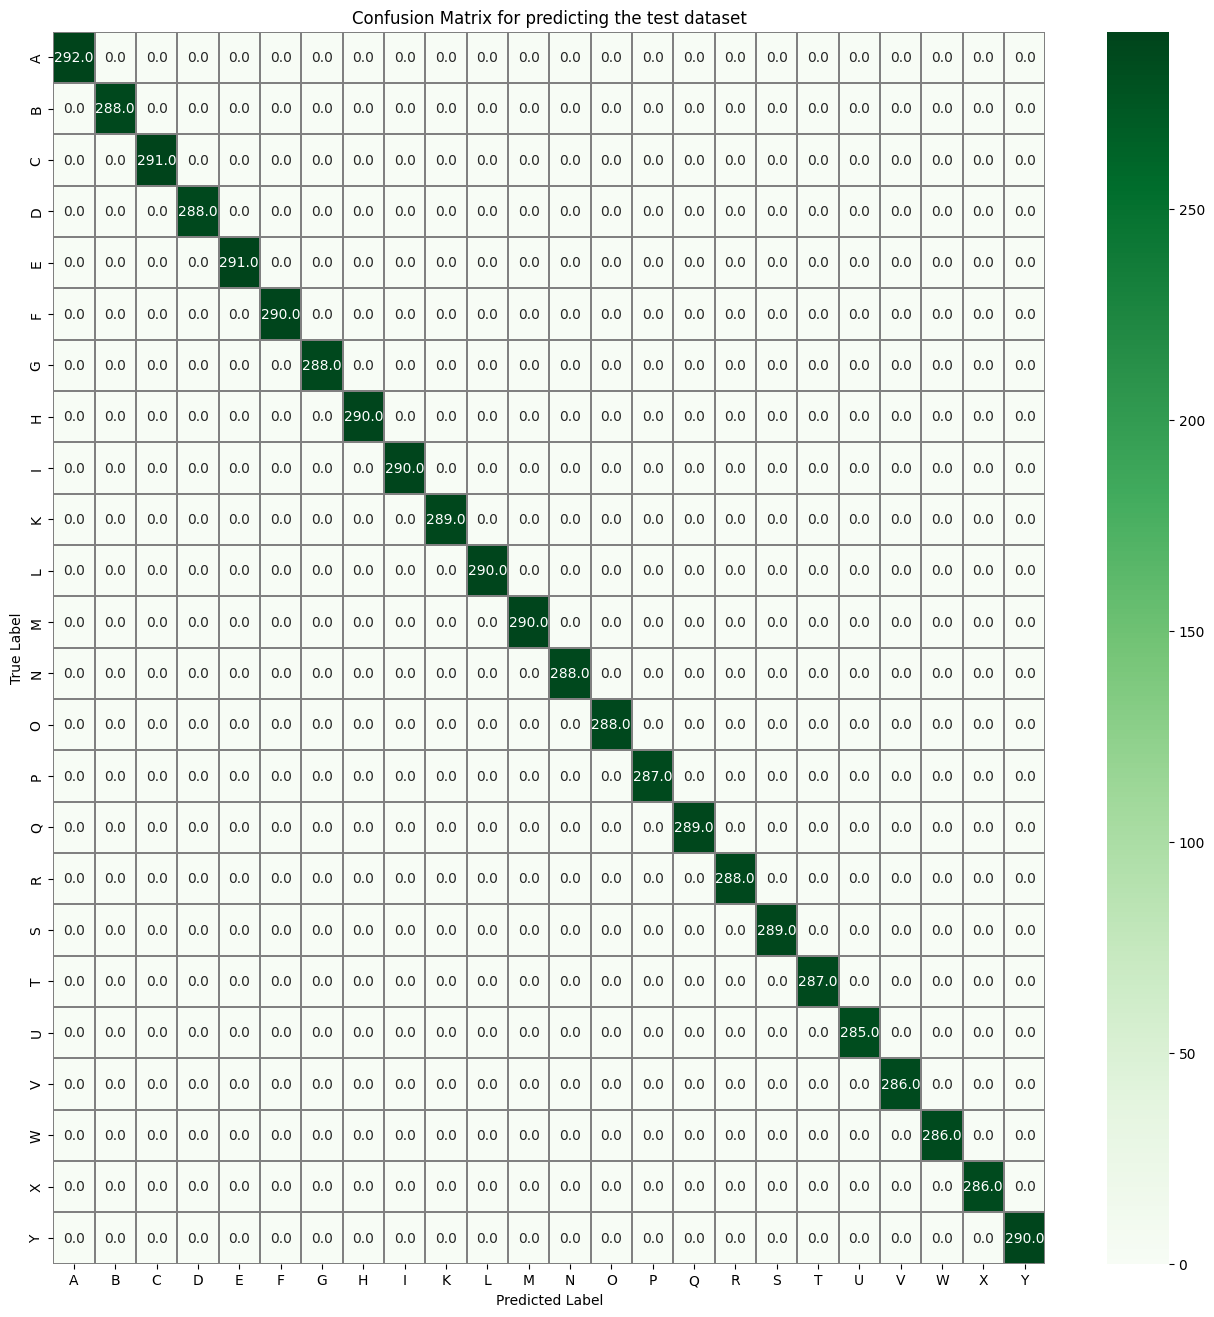

In [7]:
cnn_cv_results = CNN_algorithm(X_train, X_test, y_train, y_test)

In [20]:
print("\nAll CNN Training Times (per fold):")
print(list_cv_train_time)



All CNN Training Times (per fold):


NameError: name 'list_cv_train_time' is not defined

In [8]:
def LSTM_algorithm(X_train, X_test, y_train, y_test):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import classification_report, precision_recall_fscore_support
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    import numpy as np
    import time

    # Normalize the data (Preprocessing)
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    # Reshape the input data for LSTM [samples, timesteps, features]
    X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])  # 1 timestep
    X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

    # Hyperparameters
    OUTPUT_CLASSES = 26  # 26 classes (letters A-Z excluding J and Z)
    TIMESTEPS = 1
    FEATURES = X_train.shape[2]
    LOSS_FUNCTION = 'sparse_categorical_crossentropy'
    OPTIMIZER = 'adam'
    EPOCHS = 10
    BATCH_SIZE = 256

    # Lists to store performance metrics
    list_cv_train_time = []
    list_cv_accuracy = []
    list_cv_precision = []
    list_cv_recall = []
    list_cv_f1_score = []

    # Stratified K-fold cross validation on the training set
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    fold = 1
    for train_idx, val_idx in skf.split(X_train[:, 0, :], y_train):
        print(f"Fold #{fold}")
        X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
        X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

        # Define the LSTM model
        model = Sequential([
            LSTM(128, input_shape=(TIMESTEPS, FEATURES), return_sequences=True),
            LSTM(64),
            Dense(32, activation='relu'),
            Dense(OUTPUT_CLASSES, activation='softmax')
        ])
        model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=['accuracy'])

        # Train the model
        start_time = time.time()
        model.fit(X_train_fold, y_train_fold, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
        end_time = time.time()
        train_time = end_time - start_time

        # Evaluate on validation set
        y_pred = np.argmax(model.predict(X_val_fold), axis=-1)
        accuracy = np.mean(y_val_fold == y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_val_fold, y_pred, average='weighted', zero_division=0)

        # Store metrics
        list_cv_train_time.append(train_time)
        list_cv_accuracy.append(accuracy)
        list_cv_precision.append(precision)
        list_cv_recall.append(recall)
        list_cv_f1_score.append(f1)

        print(f"Training time: {train_time}")
        print(f"Validation accuracy: {accuracy}")
        print(f"Validation precision: {precision}")
        print(f"Validation recall: {recall}")
        print(f"Validation F1-score: {f1}")
        fold += 1

    cv_eval_metrics = [list_cv_train_time, list_cv_accuracy, list_cv_precision, list_cv_recall, list_cv_f1_score]

    # Train the final model on the entire training set
    model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

    # Evaluate on test set
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print("\nResults for predicting the test dataset:")
    print("=====================================================")
    print(classification_report(y_test, y_pred, digits=6))
    print("=====================================================")

    render_confusion_matrix(y_test, y_pred)

    return cv_eval_metrics


Fold #1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.0909 - loss: 3.0679
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3934 - loss: 2.0011
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5492 - loss: 1.4471
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6495 - loss: 1.1336
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7318 - loss: 0.8735
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7751 - loss: 0.7338
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8219 - loss: 0.5832
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8515 - loss: 0.4893
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8806 - loss: 0.3941
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9085 - loss: 0.3264
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training time: 18.388240098953247
Validation accuracy: 0.9299891735835438
Validation precision: 0.9322876464350804
V

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0869 - loss: 3.1261
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3621 - loss: 2.1155
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5551 - loss: 1.4106
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6488 - loss: 1.0880
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7230 - loss: 0.8694
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7662 - loss: 0.7332
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8233 - loss: 0.5944
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8569 - loss: 0.4974
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8852 - loss: 0.4155
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9092 - loss: 0.3371
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training time: 8.761745691299438
Validation accuracy: 0.9173285198555957
Validation precision: 0.919023311948155
Validat

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1037 - loss: 3.1020
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4201 - loss: 1.8944
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5375 - loss: 1.4384
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6348 - loss: 1.1209
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6879 - loss: 0.9559
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7578 - loss: 0.7643
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8031 - loss: 0.6440
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8290 - loss: 0.5617
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8826 - loss: 0.4306
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8944 - loss: 0.3766
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Training time: 8.528008937835693
Validation accuracy: 0.8971119133574007
Validation precision: 0.908210875344024
Validat

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0972 - loss: 3.0833
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3921 - loss: 2.0013
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5856 - loss: 1.3465
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6752 - loss: 1.0392
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7304 - loss: 0.8550
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7823 - loss: 0.7111
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8018 - loss: 0.6284
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8452 - loss: 0.5072
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8811 - loss: 0.4158
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9141 - loss: 0.3240
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training time: 8.057327270507812
Validation accuracy: 0.8880866425992779
Validation precision: 0.9076575446336332
Valida

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0997 - loss: 3.0598
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4252 - loss: 1.9097
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5540 - loss: 1.4036
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6381 - loss: 1.1222
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7140 - loss: 0.9157
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7625 - loss: 0.7569
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8089 - loss: 0.6329
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8428 - loss: 0.5271
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8744 - loss: 0.4316
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9009 - loss: 0.3561
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training time: 9.097758531570435
Validation accuracy: 0.9205776173285198
Validation precision: 0.9252974190529827
Valida

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0695 - loss: 3.1498
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3732 - loss: 2.0898
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5271 - loss: 1.4714
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6232 - loss: 1.1620
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6811 - loss: 0.9732
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7381 - loss: 0.8137
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7839 - loss: 0.6794
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8248 - loss: 0.5674
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8529 - loss: 0.4829
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8665 - loss: 0.4336
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training time: 9.008025884628296
Validation accuracy: 0.8747292418772563
Validation precision: 0.8830280592408694
Valida

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0894 - loss: 3.0979
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3668 - loss: 2.0060
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5244 - loss: 1.5069
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6185 - loss: 1.1873
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6794 - loss: 0.9865
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7326 - loss: 0.8314
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7987 - loss: 0.6687
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8183 - loss: 0.5783
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8422 - loss: 0.5073
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8864 - loss: 0.3918
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training time: 9.229069709777832
Validation accuracy: 0.903971119133574
Validation precision: 0.9135362295739314
Valida

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0946 - loss: 3.0993
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3926 - loss: 1.9953
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5625 - loss: 1.3782
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6652 - loss: 1.0642
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7407 - loss: 0.8362
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7757 - loss: 0.7141
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8298 - loss: 0.5721
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8635 - loss: 0.4747
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8841 - loss: 0.4075
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9182 - loss: 0.3108
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training time: 7.418229818344116
Validation accuracy: 0.9310469314079423
Validation precision: 0.9370168625929383
Valida

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1045 - loss: 3.0777
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4080 - loss: 1.8961
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5417 - loss: 1.4332
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6427 - loss: 1.1193
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7080 - loss: 0.9187
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7599 - loss: 0.7594
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7935 - loss: 0.6519
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8258 - loss: 0.5652
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8805 - loss: 0.4205
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9036 - loss: 0.3555
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training time: 8.771363496780396
Validation accuracy: 0.9252707581227437
Validation precision: 0.9265429580337708
Valida

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0923 - loss: 3.0761
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4293 - loss: 1.8516
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5423 - loss: 1.4209
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6328 - loss: 1.1428
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7069 - loss: 0.9326
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7469 - loss: 0.8051
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8100 - loss: 0.6382
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8466 - loss: 0.5204
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8761 - loss: 0.4400
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8959 - loss: 0.3625
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training time: 9.323763608932495
Validation accuracy: 0.8989169675090253
Validation precision: 0.9095049177573947
Valida

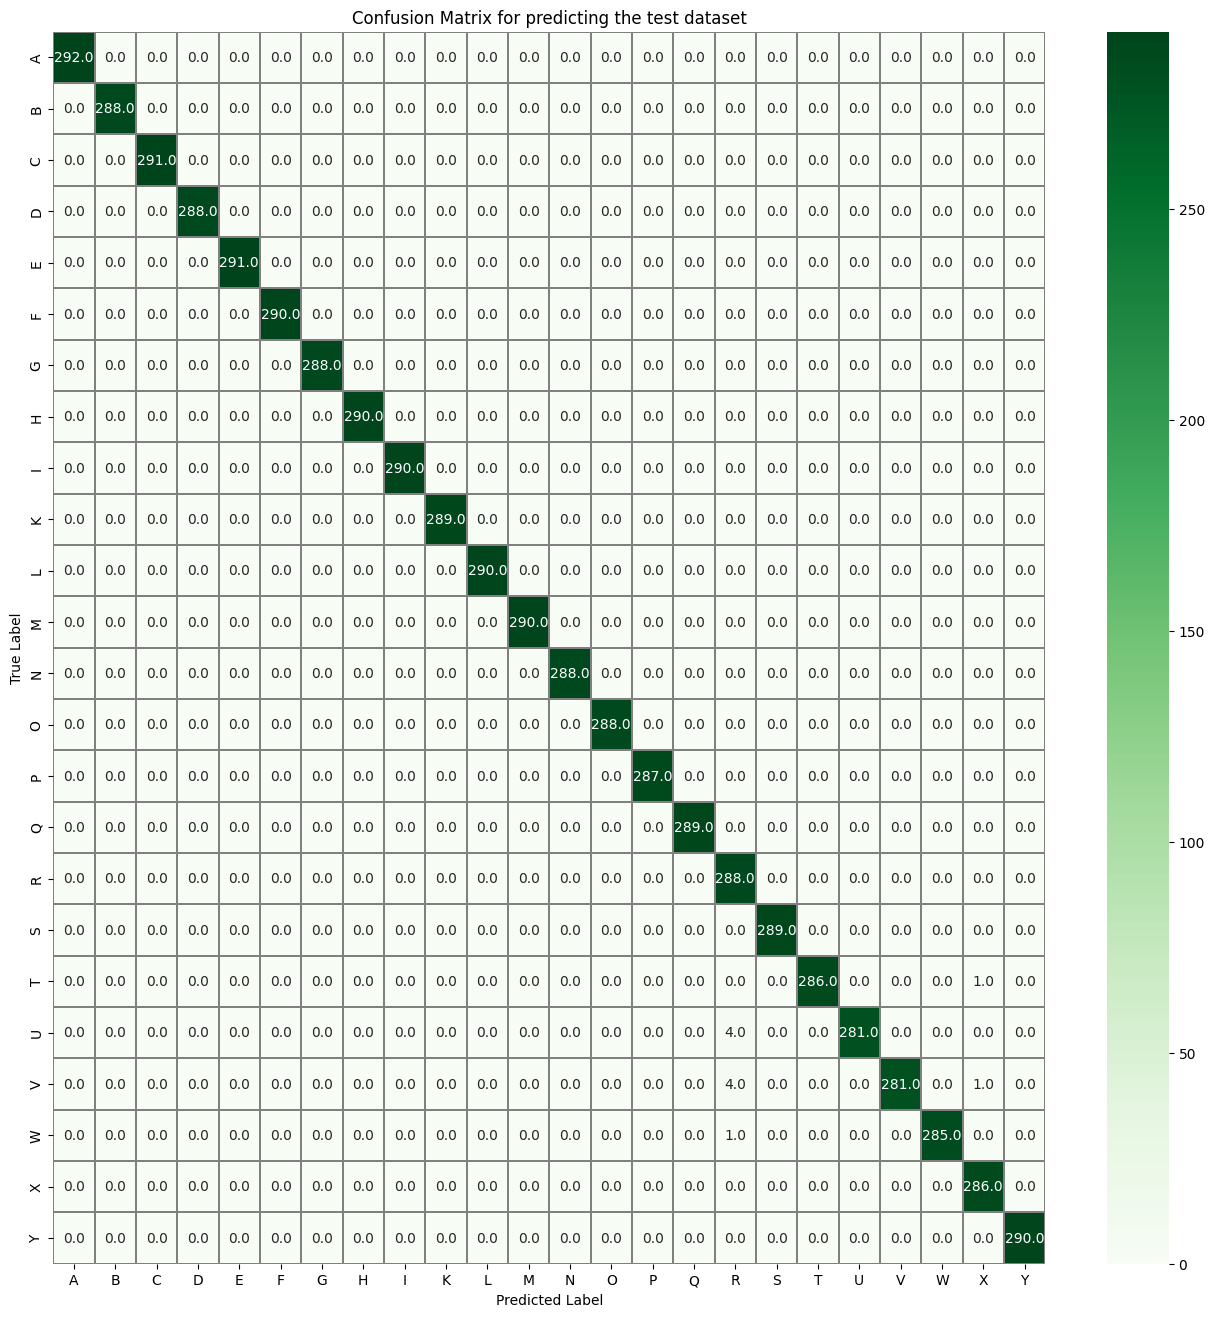

In [9]:
LSTM_cv_results = LSTM_algorithm(X_train, X_test, y_train, y_test)

In [10]:
def CNN_LSTM_algorithm(X_train, X_test, y_train, y_test):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import classification_report, precision_recall_fscore_support
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense
    import numpy as np
    import time

    # Normalize the data (Preprocessing)
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    # Reshape the input data for CNN [samples, height, width, channels]
    X_train = X_train.values.reshape(-1, 28, 28, 1)  # 28x28 images with 1 channel
    X_test = X_test.values.reshape(-1, 28, 28, 1)

    # Hyperparameters
    IMAGE_SIZE = (28, 28, 1)
    OUTPUT_CLASSES = 26  # 26 classes (letters A-Z excluding J and Z)
    KERNEL = (3, 3)
    POOL_SIZE = (2, 2)
    LSTM_UNITS = 64
    LOSS_FUNCTION = 'sparse_categorical_crossentropy'
    OPTIMIZER = 'adam'
    EPOCHS = 10
    BATCH_SIZE = 256

    # Lists to store performance metrics
    list_cv_train_time = []
    list_cv_accuracy = []
    list_cv_precision = []
    list_cv_recall = []
    list_cv_f1_score = []

    # Stratified K-fold cross validation on the training set
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    fold = 1
    for train_idx, val_idx in skf.split(X_train[:, :, :, 0], y_train):
        print(f"Fold #{fold}")
        X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
        X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

        # Define the CNN + LSTM model
        model = Sequential([
            # CNN layers
            Conv2D(filters=32, kernel_size=KERNEL, activation='relu', input_shape=IMAGE_SIZE),
            MaxPooling2D(pool_size=POOL_SIZE),
            Flatten(),

            # Dynamically compute reshape dimensions
            Reshape((-1, 32)),  # Automatically calculate timesteps from the flattened output

            # LSTM layers
            LSTM(128, return_sequences=True),
            LSTM(LSTM_UNITS),

            # Dense layers
            Dense(64, activation='relu'),
            Dense(OUTPUT_CLASSES, activation='softmax')
        ])
        model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=['accuracy'])

        # Train the model
        start_time = time.time()
        model.fit(X_train_fold, y_train_fold, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
        end_time = time.time()
        train_time = end_time - start_time

        # Evaluate on validation set
        y_pred = np.argmax(model.predict(X_val_fold), axis=-1)
        accuracy = np.mean(y_val_fold == y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_val_fold, y_pred, average='weighted', zero_division=0)

        # Store metrics
        list_cv_train_time.append(train_time)
        list_cv_accuracy.append(accuracy)
        list_cv_precision.append(precision)
        list_cv_recall.append(recall)
        list_cv_f1_score.append(f1)

        print(f"Training time: {train_time}")
        print(f"Validation accuracy: {accuracy}")
        print(f"Validation precision: {precision}")
        print(f"Validation recall: {recall}")
        print(f"Validation F1-score: {f1}")
        fold += 1

    cv_eval_metrics = [list_cv_train_time, list_cv_accuracy, list_cv_precision, list_cv_recall, list_cv_f1_score]

    # Train the final model on the entire training set
    model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

    # Evaluate on test set
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print("\nResults for predicting the test dataset:")
    print("=====================================================")
    print(classification_report(y_test, y_pred, digits=6))
    print("=====================================================")

    render_confusion_matrix(y_test, y_pred)
    return cv_eval_metrics


Fold #1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.0500 - loss: 3.2033
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1389 - loss: 2.8119
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.2460 - loss: 2.3343
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2957 - loss: 2.1626
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3849 - loss: 1.8357
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4548 - loss: 1.5931
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4937 - loss: 1.4904
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5305 - loss: 1.3537
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5746 - loss: 1.1951
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6026 - loss: 1.1124
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Training time: 35.16247892379761
Validation accuracy: 0.6423673763984121
Validation precision: 0.658176345602

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.0457 - loss: 3.2124
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1127 - loss: 2.9433
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2698 - loss: 2.2793
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3707 - loss: 1.9265
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4515 - loss: 1.6182
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5219 - loss: 1.4102
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5531 - loss: 1.2761
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6080 - loss: 1.1043
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6662 - loss: 0.9193
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7310 - loss: 0.7473
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Training time: 43.060500144958496
Validation accuracy: 0.6953068592057762
Validation precision: 0.714919554877

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.0458 - loss: 3.2176
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.0833 - loss: 3.0471
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.1952 - loss: 2.5504
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2763 - loss: 2.1589
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3799 - loss: 1.8109
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4864 - loss: 1.4959
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5461 - loss: 1.3149
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5968 - loss: 1.1491
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6448 - loss: 1.0042
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6872 - loss: 0.8875
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Training time: 39.61725211143494
Validation accuracy: 0.6646209386281589
Validation precision: 0.6737859047442

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.0433 - loss: 3.2165
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0775 - loss: 3.0976
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.1401 - loss: 2.8526
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2211 - loss: 2.4388
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2775 - loss: 2.1808
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3340 - loss: 1.9755
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4076 - loss: 1.7678
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4786 - loss: 1.5379
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5483 - loss: 1.3202
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5955 - loss: 1.1855
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Training time: 38.44364809989929
Validation accuracy: 0.6563176895306859
Validation precision: 0.659808580498

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.0475 - loss: 3.2031
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1119 - loss: 2.9520
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.2126 - loss: 2.5202
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2991 - loss: 2.1535
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3984 - loss: 1.8365
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4498 - loss: 1.6410
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5134 - loss: 1.4333
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5614 - loss: 1.2693
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6167 - loss: 1.0944
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6781 - loss: 0.9457
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Training time: 45.16367483139038
Validation accuracy: 0.6898916967509026
Validation precision: 0.6953074011170

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.0458 - loss: 3.2042
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.0824 - loss: 3.0707
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1493 - loss: 2.7358
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.2542 - loss: 2.2372
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3262 - loss: 1.9966
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4262 - loss: 1.6738
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4976 - loss: 1.4483
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5047 - loss: 1.4143
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6016 - loss: 1.1012
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6635 - loss: 0.9382
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Training time: 45.468477964401245
Validation accuracy: 0.6494584837545126
Validation precision: 0.665847001798

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.0442 - loss: 3.2106
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.1078 - loss: 2.9684
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2429 - loss: 2.3998
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3510 - loss: 1.9916
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4286 - loss: 1.7300
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.4847 - loss: 1.5403
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5571 - loss: 1.3049
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5912 - loss: 1.1958
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6492 - loss: 1.0200
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6881 - loss: 0.8820
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Training time: 39.068328619003296
Validation accuracy: 0.7530685920577618
Validation precision: 0.763527102716

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.0494 - loss: 3.2052
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.0879 - loss: 3.0200
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.1902 - loss: 2.5350
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2867 - loss: 2.1679
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.3784 - loss: 1.8524
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4266 - loss: 1.7037
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5056 - loss: 1.4520
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5727 - loss: 1.2158
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6150 - loss: 1.0924
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6377 - loss: 1.0225
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Training time: 46.76242995262146
Validation accuracy: 0.7028880866425993
Validation precision: 0.725347529205

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.0493 - loss: 3.2079
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.1012 - loss: 2.9792
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.2488 - loss: 2.3792
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3363 - loss: 2.0469
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3720 - loss: 1.9162
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4338 - loss: 1.6742
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4964 - loss: 1.4877
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5275 - loss: 1.3756
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5662 - loss: 1.2516
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6040 - loss: 1.1287
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Training time: 42.360180616378784
Validation accuracy: 0.632129963898917
Validation precision: 0.6399300968002

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.0457 - loss: 3.2122
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.0849 - loss: 3.0660
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1708 - loss: 2.7046
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2995 - loss: 2.1853
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.3984 - loss: 1.8279
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5060 - loss: 1.4436
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6013 - loss: 1.1520
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6684 - loss: 0.9318
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7364 - loss: 0.7581
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7673 - loss: 0.6606
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Training time: 44.49134826660156
Validation accuracy: 0.8209386281588448
Validation precision: 0.8232851713505

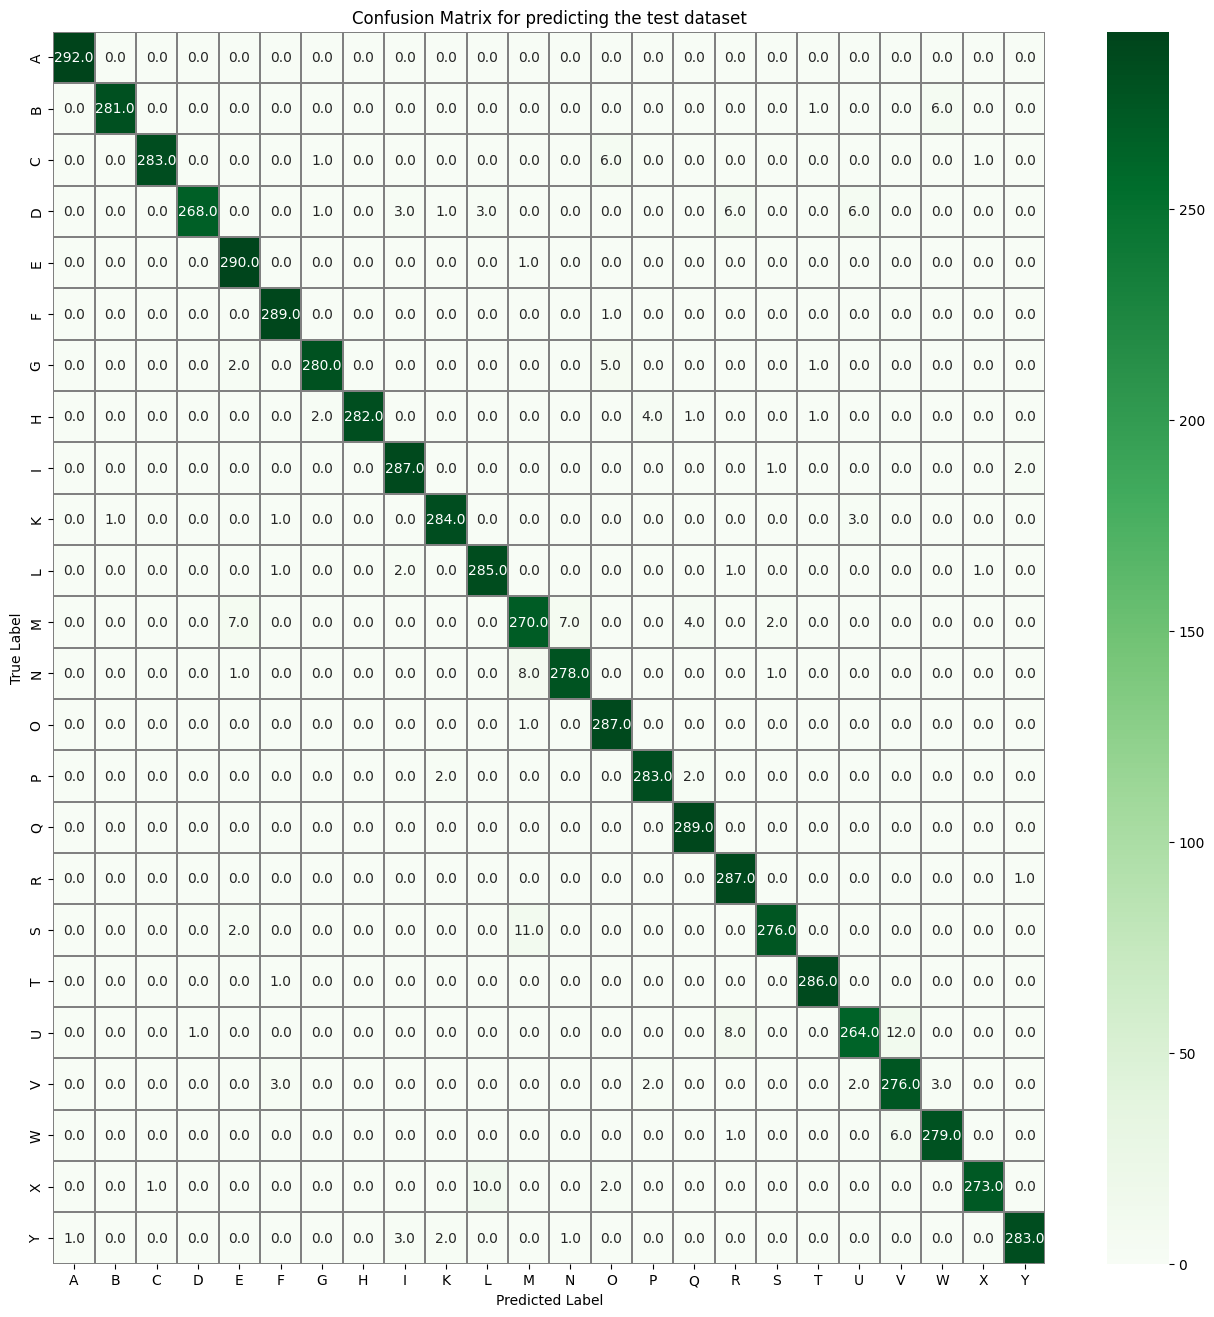

In [11]:
cnn_lstm_cv_results = CNN_LSTM_algorithm(X_train, X_test, y_train, y_test)

In [12]:
def cv_tabulate(cv_results):
    import pandas as pd
    import numpy as np
    from tabulate import tabulate

    # Ensure input is valid
    if len(cv_results) != 3 or not all(len(cv_results[0]) == len(r) for r in cv_results):
        raise ValueError("cv_results must contain three lists of equal length.")

    # Define column headers
    HEADER = ["Fold", "CNN", "LSTM", "CNN+LSTM"]

    # Extract results for each model
    cv_cnn = cv_results[0]
    cv_lstm = cv_results[1]
    cv_lstm_cnn = cv_results[2]

    # Create a DataFrame from the results
    dict_data = {
        HEADER[1]: cv_cnn,
        HEADER[2]: cv_lstm,
        HEADER[3]: cv_lstm_cnn,
    }
    df_data = pd.DataFrame(dict_data)

    # Set fold numbers
    df_data.index = np.arange(1, len(df_data) + 1)
    df_data[HEADER[0]] = df_data.index
    col_fold = df_data.pop(HEADER[0])  # Reorder the "Fold" column to the front
    df_data.insert(0, HEADER[0], col_fold)

    # Calculate metrics for each model
    min_cnn = min(cv_cnn)
    min_lstm = min(cv_lstm)
    min_lstm_cnn = min(cv_lstm_cnn)

    max_cnn = max(cv_cnn)
    max_lstm = max(cv_lstm)
    max_lstm_cnn = max(cv_lstm_cnn)

    avg_cnn = sum(cv_cnn) / len(cv_cnn)
    avg_lstm = sum(cv_lstm) / len(cv_lstm)
    avg_lstm_cnn = sum(cv_lstm_cnn) / len(cv_lstm_cnn)

    stdev_cnn = df_data[HEADER[1]].std()
    stdev_lstm = df_data[HEADER[2]].std()
    stdev_lstm_cnn = df_data[HEADER[3]].std()

    # Create a DataFrame for summary statistics
    df_avg_and_stdev = pd.DataFrame(
        [
            ["-", "-", "-", "-"],
            ["min", min_cnn, min_lstm, min_lstm_cnn],
            ["max", max_cnn, max_lstm, max_lstm_cnn],
            ["-", "-", "-", "-"],
            ["avg", avg_cnn, avg_lstm, avg_lstm_cnn],
            ["stdev", stdev_cnn, stdev_lstm, stdev_lstm_cnn],
        ],
        columns=HEADER,
    )

    # Combine results and summary statistics
    df_result = pd.concat([df_data, df_avg_and_stdev], ignore_index=True)

    # Display the results using tabulate
    print(tabulate(df_result, headers=HEADER, showindex=False, tablefmt="rst"))


In [13]:
def Friedman_and_Nemenyi_tests(cv_list, highest_is_best):
    import numpy as np
    from scipy.stats import friedmanchisquare
    from scikit_posthocs import posthoc_nemenyi_friedman

    if len(cv_list) < 2:
        raise ValueError("cv_list must contain at least two sets of results.")

    # Extract model names dynamically
    model_names = [f"Model {i+1}" for i in range(len(cv_list))]
    ALPHA = 0.05

    # Friedman test
    statistic, pvalue = friedmanchisquare(*cv_list)
    print(f"\nFriedman statistic (ratio): {statistic}")
    print(f"P-value: {pvalue}")
    print(f"Alpha: {ALPHA}")

    if pvalue < ALPHA:
        print("\nThe p-value is less than alpha (significance level).")
        print("The difference between some of the averages is statistically significant.")
        print("The null hypothesis (H0) is rejected!")

        # Nemenyi post-hoc test
        results_array = np.array(cv_list).T
        df_nemenyi = posthoc_nemenyi_friedman(results_array)

        print("\nNemenyi Post-Hoc Test Results (P-Values):")
        print(df_nemenyi)

        # Interpret pair-wise comparisons
        for i in range(len(model_names)):
            for j in range(i + 1, len(model_names)):
                p_value = df_nemenyi.iloc[i, j]
                if p_value < ALPHA:
                    if highest_is_best:
                        print(f"The algorithm {model_names[j]} performs significantly better than {model_names[i]}!")
                    else:
                        print(f"The algorithm {model_names[i]} performs significantly better than {model_names[j]}!")

    else:
        print("\nThe p-value is greater than alpha (significance level).")
        print("The difference between the averages is NOT statistically significant.")


In [25]:
# Extract training times
training_time_cnn = cnn_lstm_cv_results[0]
training_time_lstm = LSTM_cv_results[0]
training_time_cnn_lstm = cnn_lstm_cv_results[0]

# Print all training times
print(f"CNN Training Times: {training_time_cnn}")
print(f"LSTM Training Times: {training_time_lstm}")
print(f"CNN+LSTM Training Times: {training_time_cnn_lstm}")


CNN Training Times: [35.16247892379761, 43.060500144958496, 39.61725211143494, 38.44364809989929, 45.16367483139038, 45.468477964401245, 39.068328619003296, 46.76242995262146, 42.360180616378784, 44.49134826660156]
LSTM Training Times: [18.388240098953247, 8.761745691299438, 8.528008937835693, 8.057327270507812, 9.097758531570435, 9.008025884628296, 9.229069709777832, 7.418229818344116, 8.771363496780396, 9.323763608932495]
CNN+LSTM Training Times: [35.16247892379761, 43.060500144958496, 39.61725211143494, 38.44364809989929, 45.16367483139038, 45.468477964401245, 39.068328619003296, 46.76242995262146, 42.360180616378784, 44.49134826660156]


---
Cross-validation followed by Friedman and Nemenyi tests for each performance metric:

In [26]:
from itertools import chain
# Extract training times for each model
# Truncate CNN training times to match the minimum length (5 folds)
min_length = min(len(training_time_cnn), len(training_time_lstm), len(training_time_cnn_lstm))


training_time_cnn = training_time_cnn[:min_length]
training_time_lstm = training_time_lstm[:min_length]
training_time_cnn_lstm = training_time_cnn_lstm[:min_length]

cv_training_time = [training_time_cnn, training_time_lstm, training_time_cnn_lstm]


# Print tabulated results
print("Cross-validation results of computational performance in terms of training time:")
cv_tabulate(cv_training_time)

# Perform Friedman and Nemenyi tests
Friedman_and_Nemenyi_tests(cv_training_time, highest_is_best=False)


Cross-validation results of computational performance in terms of training time:
======  ==================  ==================  ==================
Fold    CNN                 LSTM                CNN+LSTM
======  ==================  ==================  ==================
1       35.16247892379761   18.388240098953247  35.16247892379761
2       43.060500144958496  8.761745691299438   43.060500144958496
3       39.61725211143494   8.528008937835693   39.61725211143494
4       38.44364809989929   8.057327270507812   38.44364809989929
5       45.16367483139038   9.097758531570435   45.16367483139038
6       45.468477964401245  9.008025884628296   45.468477964401245
7       39.068328619003296  9.229069709777832   39.068328619003296
8       46.76242995262146   7.418229818344116   46.76242995262146
9       42.360180616378784  8.771363496780396   42.360180616378784
10      44.49134826660156   9.323763608932495   44.49134826660156
-       -                   -                   -
min     35.162

In [27]:
print("Length of LSTM_cv_results:", len(LSTM_cv_results))
print("Length of cnn_lstm_cv_results:", len(cnn_lstm_cv_results))
print("Length of cnn_cv_results:", len(cnn_cv_results))


Length of LSTM_cv_results: 5
Length of cnn_lstm_cv_results: 5
Length of cnn_cv_results: 5


In [28]:
# Accuracy score
accuracy_knn = cnn_cv_results[1]
accuracy_svm = LSTM_cv_results[1]
accuracy_cnn = cnn_lstm_cv_results[1]
cv_accuracy = [accuracy_knn, accuracy_svm, accuracy_cnn]

print("Cross-validation results of predictive performance based on accuracy:")
cv_tabulate(cv_accuracy)

Friedman_and_Nemenyi_tests(cv_accuracy, True)

Cross-validation results of predictive performance based on accuracy:
======  =====================  ====================  ===================
Fold    CNN                    LSTM                  CNN+LSTM
======  =====================  ====================  ===================
1       1.0                    0.9299891735835438    0.6423673763984121
2       1.0                    0.9173285198555957    0.6953068592057762
3       0.9992779783393502     0.8971119133574007    0.6646209386281589
4       0.9974729241877256     0.8880866425992779    0.6563176895306859
5       0.9992779783393502     0.9205776173285198    0.6898916967509026
6       0.9992779783393502     0.8747292418772563    0.6494584837545126
7       1.0                    0.903971119133574     0.7530685920577618
8       0.9996389891696751     0.9310469314079423    0.7028880866425993
9       0.9985559566787003     0.9252707581227437    0.632129963898917
10      1.0                    0.8989169675090253    0.8209386281588448
-  

In [29]:
# Precision score
precision_lstm = LSTM_cv_results[2]
precision_cnn_lstm = cnn_lstm_cv_results[2]
precision_cnn = cnn_cv_results[2]
cv_precision = [precision_lstm, precision_cnn_lstm, precision_cnn]

print("Cross-validation results of predictive performance based on precision:")
cv_tabulate(cv_precision)


Friedman_and_Nemenyi_tests(cv_precision, True)

Cross-validation results of predictive performance based on precision:
======  ===================  ===================  =====================
Fold    CNN                  LSTM                 CNN+LSTM
======  ===================  ===================  =====================
1       0.9322876464350804   0.658176345602536    1.0
2       0.919023311948155    0.7149195548779667   1.0
3       0.908210875344024    0.6737859047442528   0.999284229726292
4       0.9076575446336332   0.6598085804987823   0.9975129080239972
5       0.9252974190529827   0.695307401117092    0.999284202664011
6       0.8830280592408694   0.6658470017984264   0.999284202664011
7       0.9135362295739314   0.7635271027160901   1.0
8       0.9370168625929383   0.725347529205609    0.9996421283942865
9       0.9265429580337708   0.6399300968002637   0.9985743654592704
10      0.9095049177573947   0.8232851713505817   1.0
-       -                    -                    -
min     0.8830280592408694   0.6399300968002637

In [30]:
# Recall score
recall_lstm = LSTM_cv_results[3]
recall_cnn_lstm = cnn_lstm_cv_results[3]
recall_cnn = cnn_cv_results[3]
cv_recall = [recall_lstm, recall_cnn_lstm, recall_cnn]
print("Cross-validation results of predictive performance based on recall:")
cv_tabulate(cv_recall)

Friedman_and_Nemenyi_tests(cv_recall, True)

Cross-validation results of predictive performance based on recall:
======  ====================  ===================  =====================
Fold    CNN                   LSTM                 CNN+LSTM
======  ====================  ===================  =====================
1       0.9299891735835438    0.6423673763984121   1.0
2       0.9173285198555957    0.6953068592057762   1.0
3       0.8971119133574007    0.6646209386281589   0.9992779783393502
4       0.8880866425992779    0.6563176895306859   0.9974729241877256
5       0.9205776173285198    0.6898916967509026   0.9992779783393502
6       0.8747292418772563    0.6494584837545126   0.9992779783393502
7       0.903971119133574     0.7530685920577618   1.0
8       0.9310469314079423    0.7028880866425993   0.9996389891696751
9       0.9252707581227437    0.632129963898917    0.9985559566787003
10      0.8989169675090253    0.8209386281588448   1.0
-       -                     -                    -
min     0.8747292418772563    0.6

In [31]:
# F1-score / F-Measure
f1_score_knn = LSTM_cv_results[4]
f1_score_svm = cnn_lstm_cv_results[4]
f1_score_cnn = cnn_cv_results[4]
cv_f1_score = [f1_score_knn, f1_score_svm, f1_score_cnn]
print("Cross-validation results of predictive performance based on F1-score / F-measure:")
cv_tabulate(cv_f1_score)

Friedman_and_Nemenyi_tests(cv_f1_score, True)

Cross-validation results of predictive performance based on F1-score / F-measure:
======  ====================  ===================  =====================
Fold    CNN                   LSTM                 CNN+LSTM
======  ====================  ===================  =====================
1       0.9297193941975626    0.6335279580914965   1.0
2       0.9167152608631192    0.6923243652169738   1.0
3       0.8967463355237311    0.6590467561478353   0.9992779783393502
4       0.8876852930911628    0.647420577449337    0.9974710656316995
5       0.9209025060743059    0.6832513482905851   0.9992779712774046
6       0.8747313206124278    0.6407167248168409   0.9992779715148198
7       0.9050957801987533    0.7490720744786182   1.0
8       0.9299617047867953    0.6998514051127458   0.9996389822248888
9       0.9248391095030157    0.6187542169501737   0.9985558827774687
10      0.9004975834658839    0.817974236123596    1.0
-       -                     -                    -
min     0.874731320